Agent state won't persist in second turn

In [1]:
from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery

from langsmith import traceable, get_current_run_tree

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

from langchain_core.messages import AIMessage, ToolMessage

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import inspect
import instructor
import json

# Define a Retrival Tool

In [53]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )

    current_run = get_current_run_tree()
    if current_run:
        current_run.metadata["usage_metadata"] = {
            "input_tokens": response.usage.prompt_tokens,
            "total_tokens": response.usage.total_tokens,
        }

    return response.data[0].embedding


@traceable(
    name="retrieve_top_n",
    run_type="retriever"
)
def retrieve_context(query, top_k=5):
    query_embedding = get_embedding(query)

    qdrant_client = QdrantClient(url="http://localhost:6333")

    results = qdrant_client.query_points(
        collection_name="job-postings-collection-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                limit=20
            ),
            Prefetch(
                filter=Filter(
                    must=[
                        FieldCondition(
                            key="text",
                            match=MatchText(text=query)
                        )
                    ]
                ),
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=top_k
    )

    retrieved_context_ids = []
    retrieved_context = []
    similarity_scores = []

    for result in results.points:
        retrieved_context_ids.append(result.id)
        retrieved_context.append(result.payload['text'])
        similarity_scores.append(result.score)

    return {
        "retrieved_context_ids": retrieved_context_ids,
        "retrieved_context": retrieved_context,
        "similarity_scores": similarity_scores
    }


@traceable(
    name="format_retrieved_context",
    run_type="prompt"
)
def process_context(context):

    formatted_context = ""

    for id, chunk in zip(context["retrieved_context_ids"], context["retrieved_context"]):
        formatted_context += f"- {id}: {chunk}\n"
    return formatted_context


def get_formatted_context(query: str, top_k: int = 5) -> str:

    """Get the top k context, each representing an job posting for a given query.
    
    Args:
        query: The query to get the top k context for
        top_k: The number of context chunks to retrieve, works best with 5 or more
    
    Returns:
        A string of the top k context chunks with IDs prepending each chunk, each representing job posting for a given query.
    """

    context = retrieve_context(query, top_k)
    formatted_context = process_context(context)

    return formatted_context

# Helpers

In [54]:
def parse_function_definition(function_def: str) -> Dict[str, Any]:
    """Parse a function definition string to extract metadata including type hints."""
    result = {
        "name": "",
        "description": "",
        "parameters": {"type": "object", "properties": {}},
        "required": [],
        "returns": {"type": "string", "description": ""}
    }
    
    # Parse the function using AST
    tree = ast.parse(function_def.strip())
    if not tree.body or not isinstance(tree.body[0], ast.FunctionDef):
        return result
        
    func = tree.body[0]
    result["name"] = func.name
    
    # Extract docstring
    docstring = ast.get_docstring(func) or ""
    if docstring:
        # Extract description (first line/paragraph)
        desc_end = docstring.find('\n\n') if '\n\n' in docstring else docstring.find('\nArgs:')
        desc_end = desc_end if desc_end > 0 else docstring.find('\nParameters:')
        result["description"] = docstring[:desc_end].strip() if desc_end > 0 else docstring.strip()
        
        # Parse parameter descriptions
        param_descs = parse_docstring_params(docstring)
        
        # Extract return description
        if "Returns:" in docstring:
            result["returns"]["description"] = docstring.split("Returns:")[1].strip().split('\n')[0]
    
    # Extract parameters with type hints
    args = func.args
    defaults = args.defaults
    num_args = len(args.args)
    num_defaults = len(defaults)
    
    for i, arg in enumerate(args.args):
        if arg.arg == 'self':
            continue
            
        param_info = {
            "type": get_type_from_annotation(arg.annotation) if arg.annotation else "string",
            "description": param_descs.get(arg.arg, "")
        }
        
        # Check for default value
        default_idx = i - (num_args - num_defaults)
        if default_idx >= 0:
            param_info["default"] = ast.literal_eval(ast.unparse(defaults[default_idx]))
        else:
            result["required"].append(arg.arg)
        
        result["parameters"]["properties"][arg.arg] = param_info
    
    # Extract return type
    if func.returns:
        result["returns"]["type"] = get_type_from_annotation(func.returns)
    
    return result


def get_type_from_annotation(annotation) -> str:
    """Convert AST annotation to type string."""
    if not annotation:
        return "string"
    
    type_map = {
        'str': 'string',
        'int': 'integer', 
        'float': 'number',
        'bool': 'boolean',
        'list': 'array',
        'dict': 'object',
        'List': 'array',
        'Dict': 'object'
    }
    
    if isinstance(annotation, ast.Name):
        return type_map.get(annotation.id, annotation.id)
    elif isinstance(annotation, ast.Subscript) and isinstance(annotation.value, ast.Name):
        base_type = annotation.value.id
        return type_map.get(base_type, base_type.lower())
    
    return "string"


def parse_docstring_params(docstring: str) -> Dict[str, str]:
    """Extract parameter descriptions from docstring (handles both Args: and Parameters: formats)."""
    params = {}
    lines = docstring.split('\n')
    in_params = False
    current_param = None
    
    for line in lines:
        stripped = line.strip()
        
        # Check for parameter section start
        if stripped in ['Args:', 'Arguments:', 'Parameters:', 'Params:']:
            in_params = True
            current_param = None
        elif stripped.startswith('Returns:') or stripped.startswith('Raises:'):
            in_params = False
        elif in_params:
            # Parse parameter line (handles "param: desc" and "- param: desc" formats)
            if ':' in stripped and (stripped[0].isalpha() or stripped.startswith(('-', '*'))):
                param_name = stripped.lstrip('- *').split(':')[0].strip()
                param_desc = ':'.join(stripped.lstrip('- *').split(':')[1:]).strip()
                params[param_name] = param_desc
                current_param = param_name
            elif current_param and stripped:
                # Continuation of previous parameter description
                params[current_param] += ' ' + stripped
    
    return params
def get_tool_descriptions_from_node(tool_node):
    """Extract tool descriptions from the ToolNode object."""
    descriptions = []
    
    if hasattr(tool_node, 'tools_by_name'):
        tools_by_name = tool_node.tools_by_name
        
        for tool_name, tool in tools_by_name.items():
            function_string = inspect.getsource(globals()[tool_name])
            # function_string = inspect.getsource(getattr(tool_name))
            result = parse_function_definition(function_string)

            if result:
                descriptions.append(result)
    
    return descriptions if descriptions else "Could not extract tool descriptions"
def lc_messages_to_regular_messages(msg):

    if isinstance(msg, dict):
        
        if msg.get("role") == "user":
            return {"role": "user", "content": msg["content"]}
        elif msg.get("role") == "assistant":
            return {"role": "assistant", "content": msg["content"]}
        elif msg.get("role") == "tool":
            return {
                "role": "tool", 
                "content": msg["content"], 
                "tool_call_id": msg.get("tool_call_id")
            }
        
    elif isinstance(msg, AIMessage):

        result = {
            "role": "assistant",
            "content": msg.content
        }
        
        if hasattr(msg, 'tool_calls') and msg.tool_calls and len(msg.tool_calls) > 0 and not msg.tool_calls[0].get("name").startswith("functions."):
            result["tool_calls"] = [
                {
                    "id": tc["id"],
                    "type": "function",
                    "function": {
                        "name": tc["name"].replace("functions.", ""),
                        "arguments": json.dumps(tc["args"])
                    }
                }
                for tc in msg.tool_calls
            ]
            
        return result
    
    elif isinstance(msg, ToolMessage):

        return {"role": "tool", "content": msg.content, "tool_call_id": msg.tool_call_id}
    
    else:

        return {"role": "user", "content": str(msg)}

# State and Pydantic Models for structured outputs

In [55]:
class ToolCall(BaseModel):
    name: str
    arguments: dict

class RAGUsedContext(BaseModel):
    id: int
    description: str

class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)
    final_answer: bool = Field(default=False)
    retrieved_context_ids: List[RAGUsedContext]

class State(BaseModel):
    messages: Annotated[List[Any], add] = []
    answer: str = ""
    iteration: int = Field(default=0)
    final_answer: bool = Field(default=False)
    available_tools: List[Dict[str, Any]] = []
    tool_calls: Optional[List[ToolCall]] = Field(default_factory=list)
    retrieved_context_ids: Annotated[List[RAGUsedContext], add] = []

# Agent Node

In [56]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def agent_node(state: State) -> dict:

   prompt_template =  """You are a Fraud Analyst Assistant. The user is a Fraud Analyst and your job is to determine whether a job posting is real or fraudulent. 
        Use your knowledge of common fraud indicators, best practices for job verification, and any relevant information you can retrieve to support your answer.
        Always explain your reasoning and provide actionable advice. 

        User may provide either the full job posting text, job title, or a job ID. 

        If a job ID is provided, retrieve the corresponding job posting details before analysis.

You will be given a question and a list of tools you can use to answer that question.

<Available tools>
{{ available_tools | tojson }}
</Available tools>

After the tools are used you will get the outputs from the tools.

When you need to use a tool, format your response as:

<tool_call>
{"name": "tool_name", "arguments": {...}}
</tool_call>

Use names specifically provided in the available tools. Don't add any additional text to the names.

You should tend to use tools when additional information is needed to answer the question.

If you set final_answer to True, you should not use any tools.

Instructions:
   1. Carefully analyze the provided job details and user input above.
   2. Use up-to-date information about job scams, legitimate job ad characteristics, and known fraud patterns.
   3. Provide a clear verdict: "Likely Real", "Likely Fraudulent", or "Uncertain".
   4. Explain your reasoning with specific evidence from the posting, user input, and retrieved information.
   5. List any red flags or positive signs you identified.
   6. Offer actionable advice to the user.
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      available_tools=state.available_tools
   )

   messages = state.messages

   conversation = []

   for msg in messages:
      conversation.append(lc_messages_to_regular_messages(msg))

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AgentResponse,
        messages=[{"role": "system", "content": prompt}, *conversation],
        temperature=0.5,
   )

   if response.tool_calls:
      tool_calls = []
      for i, tc in enumerate(response.tool_calls):
         tool_calls.append({
               "id": f"call_{i}",
               "name": tc.name,
               "args": tc.arguments
         })

      ai_message = AIMessage(
         content=response.answer,
         tool_calls=tool_calls
         )
   else:
      ai_message = AIMessage(
         content=response.answer,
      )

   return {
      "messages": [ai_message],
      "tool_calls": response.tool_calls,
      "iteration": state.iteration + 1,
      "answer": response.answer,
      "final_answer": response.final_answer,
      "retrieved_context_ids": response.retrieved_context_ids
   }

# Router node

In [57]:
def tool_router(state: State) -> str:
    """Decide whether to continue or end"""
    
    if state.final_answer:
        return "end"
    elif state.iteration > 2:
        return "end"
    elif len(state.tool_calls) > 0:
        return "tools"
    else:
        return "end"

# Graph

In [65]:
workflow = StateGraph(State)

tools = [get_formatted_context]
tool_node = ToolNode(tools)

tool_descriptions = get_tool_descriptions_from_node(tool_node)

workflow.add_node("agent_node", agent_node)
workflow.add_node("tool_node", tool_node)

workflow.add_edge(START, "agent_node")

workflow.add_conditional_edges(
    "agent_node",
    tool_router,
    {
        "tools": "tool_node",
        "end": END
    }
)

workflow.add_edge("tool_node", "agent_node")

graph = workflow.compile()

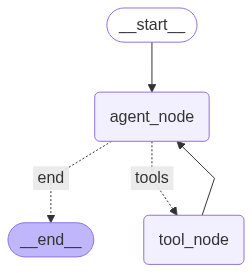

In [59]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [68]:
initial_state = {
    "messages": [{"role": "user", "content": "Tell me if the following job postings are real or not: 10397,  5485, and 16447"}],
    "available_tools": tool_descriptions
}
result = graph.invoke(initial_state)

In [69]:
result

{'messages': [{'role': 'user',
   'content': 'Tell me if the following job postings are real or not: 10397,  5485, and 16447'},
  AIMessage(content='I will retrieve the details of the job postings with IDs 10397, 5485, and 16447 to analyze their authenticity.', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'get_formatted_context', 'args': {'query': '10397', 'top_k': 1}, 'id': 'call_0', 'type': 'tool_call'}, {'name': 'get_formatted_context', 'args': {'query': '5485', 'top_k': 1}, 'id': 'call_1', 'type': 'tool_call'}, {'name': 'get_formatted_context', 'args': {'query': '16447', 'top_k': 1}, 'id': 'call_2', 'type': 'tool_call'}]),
  ToolMessage(content="- 1: Director of Software Engineering Company: #URL_ddb080358fa5eecf5a67c649cfb4ffc343c484389f1bbaf2a1cb071e3f2b6e7e# and Aptitude Staffing Solutions have partnered up in an effort to streamline the hiring process and provide a more efficient and effective recruitng model.\xa0 Our focus is to help develop and achieve you